In [1]:
"""
Gutenberg Text Generation using Recurrent Neural Network (RNN)

This module implements a character-level RNN for generating Gutenberg-like text.
The implementation follows production-safe coding practices with extensive error handling,
documentation, and clear variable naming conventions.

Author: AI Assistant
Date: 2024
Purpose: Educational demonstration of basic RNN text generation
"""

'\nGutenberg Text Generation using Recurrent Neural Network (RNN)\n\nThis module implements a character-level RNN for generating Gutenberg-like text.\nThe implementation follows production-safe coding practices with extensive error handling,\ndocumentation, and clear variable naming conventions.\n\nAuthor: AI Assistant\nDate: 2024\nPurpose: Educational demonstration of basic RNN text generation\n'

In [2]:
import os
import sys
from datetime import datetime
import traceback
import logging
from typing import Dict, List, Tuple, Optional, Any
import warnings

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [3]:

# Configure logging for production safety
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger(__name__)

# Suppress warnings for cleaner output (production consideration)
warnings.filterwarnings("ignore", category=UserWarning)



In [4]:


class GutenbergTextDataset(Dataset):
    """
    Custom PyTorch Dataset class for handling Gutenberg text data.

    This class converts raw text into character-level sequences suitable for training
    an RNN model. It creates input-target pairs where the target is the next character
    in the sequence.

    Attributes:
        raw_text_content (str): The original text content
        unique_characters_sorted (List[str]): Sorted list of unique characters
        character_to_index_mapping (Dict[str, int]): Maps characters to indices
        index_to_character_mapping (Dict[int, str]): Maps indices back to characters
        sequence_length_for_training (int): Length of input sequences
        encoded_text_as_integers (List[int]): Text converted to integer indices
    """

    def __init__(self, text_file_path: str, sequence_length_for_training: int = 100):
        """
        Initialize the Gutenberg text dataset.

        Args:
            text_file_path (str): Path to the Gutenberg text file
            sequence_length_for_training (int): Length of sequences for training

        Raises:
            FileNotFoundError: If the specified text file doesn't exist
            ValueError: If sequence length is invalid
            Exception: For any other unexpected errors during initialization
        """
        try:
            logger.info(f"Initializing Gutenberg dataset from: {text_file_path}")

            # Validate input parameters
            if sequence_length_for_training <= 0:
                raise ValueError(
                    "sequence_length_for_training must be positive integer"
                )

            self.sequence_length_for_training = sequence_length_for_training

            # Read and validate text file
            text_file_path_object = Path(text_file_path)
            if not text_file_path_object.exists():
                raise FileNotFoundError(f"Text file not found: {text_file_path}")

            # Read text content with error handling
            self.raw_text_content = self._safely_read_text_file(text_file_path_object)

            # Create character mappings
            self._create_character_mappings()

            # Encode text as integers
            self._encode_text_to_integers()

            logger.info(
                f"Dataset initialized successfully. Text length: {len(self.raw_text_content)}, "
                f"Unique characters: {len(self.unique_characters_sorted)}"
            )

        except FileNotFoundError as file_error:
            logger.error(
                f"File not found error during dataset initialization: {file_error}"
            )
            traceback.print_exc()
            raise
        except ValueError as value_error:
            logger.error(f"Value error during dataset initialization: {value_error}")
            traceback.print_exc()
            raise
        except Exception as unexpected_error:
            logger.error(
                f"Unexpected error during dataset initialization: {unexpected_error}"
            )
            traceback.print_exc()
            raise

    def _safely_read_text_file(self, text_file_path_object: Path) -> str:
        """
        Safely read text file with multiple encoding attempts.

        Args:
            text_file_path_object (Path): Path object for the text file

        Returns:
            str: Content of the text file

        Raises:
            Exception: If file cannot be read with any encoding
        """
        encodings_to_try = ["utf-8", "latin-1", "cp1252", "ascii"]

        for encoding_attempt in encodings_to_try:
            try:
                logger.info(
                    f"Attempting to read file with encoding: {encoding_attempt}"
                )
                with open(
                    text_file_path_object, "r", encoding=encoding_attempt
                ) as file_handle:
                    text_content = file_handle.read()
                logger.info(f"Successfully read file with encoding: {encoding_attempt}")
                return text_content
            except UnicodeDecodeError as decode_error:
                logger.warning(
                    f"Failed to read with encoding {encoding_attempt}: {decode_error}"
                )
                continue
            except Exception as read_error:
                logger.error(
                    f"Unexpected error reading file with {encoding_attempt}: {read_error}"
                )
                continue

        raise Exception(
            f"Could not read file with any of these encodings: {encodings_to_try}"
        )

    def _create_character_mappings(self) -> None:
        """
        Create bidirectional mappings between characters and integer indices.

        This method creates dictionaries to convert between characters and their
        corresponding integer indices for neural network processing.
        """
        try:
            # Get unique characters and sort them for consistency
            unique_characters_set = set(self.raw_text_content)
            self.unique_characters_sorted = sorted(list(unique_characters_set))

            # Create character to index mapping
            self.character_to_index_mapping = {
                character: index
                for index, character in enumerate(self.unique_characters_sorted)
            }

            # Create index to character mapping (reverse mapping)
            self.index_to_character_mapping = {
                index: character
                for character, index in self.character_to_index_mapping.items()
            }

            logger.info(
                f"Created character mappings for {len(self.unique_characters_sorted)} unique characters"
            )

        except Exception as mapping_error:
            logger.error(f"Error creating character mappings: {mapping_error}")
            traceback.print_exc()
            raise

    def _encode_text_to_integers(self) -> None:
        """
        Convert text content to integer sequence using character mappings.

        Raises:
            KeyError: If a character is not found in the mapping
            Exception: For any other unexpected errors
        """
        try:
            self.encoded_text_as_integers = []

            for character in self.raw_text_content:
                if character not in self.character_to_index_mapping:
                    logger.warning(f"Character not found in mapping: {repr(character)}")
                    continue

                character_index = self.character_to_index_mapping[character]
                self.encoded_text_as_integers.append(character_index)

            logger.info(
                f"Encoded text to {len(self.encoded_text_as_integers)} integers"
            )

        except Exception as encoding_error:
            logger.error(f"Error encoding text to integers: {encoding_error}")
            traceback.print_exc()
            raise

    def __len__(self) -> int:
        """
        Return the number of training samples available.

        Returns:
            int: Number of possible training sequences
        """
        try:
            # Calculate number of possible sequences
            possible_sequences = (
                len(self.encoded_text_as_integers) - self.sequence_length_for_training
            )
            return max(0, possible_sequences)
        except Exception as length_error:
            logger.error(f"Error calculating dataset length: {length_error}")
            return 0

    def __getitem__(self, sequence_index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Get a single training sample (input sequence and target).

        Args:
            sequence_index (int): Index of the sequence to retrieve

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: Input sequence and target character

        Raises:
            IndexError: If sequence_index is out of range
            Exception: For any other unexpected errors
        """
        try:
            # Validate sequence index
            if sequence_index < 0 or sequence_index >= len(self):
                raise IndexError(
                    f"Sequence index {sequence_index} out of range [0, {len(self)})"
                )

            # Extract input sequence
            sequence_start_index = sequence_index
            sequence_end_index = sequence_index + self.sequence_length_for_training
            input_sequence_integers = self.encoded_text_as_integers[
                sequence_start_index:sequence_end_index
            ]

            # Extract target (next character)
            target_character_index = self.encoded_text_as_integers[sequence_end_index]

            # Convert to tensors
            input_sequence_tensor = torch.tensor(
                input_sequence_integers, dtype=torch.long
            )
            target_character_tensor = torch.tensor(
                target_character_index, dtype=torch.long
            )

            return input_sequence_tensor, target_character_tensor

        except IndexError as index_error:
            logger.error(f"Index error in __getitem__: {index_error}")
            traceback.print_exc()
            raise
        except Exception as getitem_error:
            logger.error(f"Unexpected error in __getitem__: {getitem_error}")
            traceback.print_exc()
            raise

    def get_vocabulary_size(self) -> int:
        """
        Get the size of the character vocabulary.

        Returns:
            int: Number of unique characters in the dataset
        """
        try:
            return len(self.unique_characters_sorted)
        except Exception as vocab_error:
            logger.error(f"Error getting vocabulary size: {vocab_error}")
            return 0

    def decode_integer_sequence_to_text(self, integer_sequence: List[int]) -> str:
        """
        Convert a sequence of integers back to text.

        Args:
            integer_sequence (List[int]): Sequence of character indices

        Returns:
            str: Decoded text string

        Raises:
            KeyError: If an integer index is not found in the mapping
            Exception: For any other unexpected errors
        """
        try:
            decoded_characters = []

            for integer_index in integer_sequence:
                if integer_index not in self.index_to_character_mapping:
                    logger.warning(
                        f"Integer index not found in mapping: {integer_index}"
                    )
                    decoded_characters.append(
                        "?"
                    )  # Use placeholder for unknown indices
                    continue

                character = self.index_to_character_mapping[integer_index]
                decoded_characters.append(character)

            decoded_text = "".join(decoded_characters)
            return decoded_text

        except Exception as decode_error:
            logger.error(f"Error decoding integer sequence to text: {decode_error}")
            traceback.print_exc()
            return ""


In [5]:

class GutenbergRNNModel(nn.Module):
    """
    Recurrent Neural Network model for Gutenberg text generation.

    This class implements a simple RNN architecture with embedding layer,
    RNN hidden layers, and output projection for character-level text generation.

    Attributes:
        vocabulary_size_for_embeddings (int): Size of character vocabulary
        embedding_dimension_size (int): Dimension of character embeddings
        hidden_state_dimension_size (int): Dimension of RNN hidden states
        number_of_rnn_layers (int): Number of stacked RNN layers
        character_embedding_layer (nn.Embedding): Converts indices to embeddings
        recurrent_neural_network_layers (nn.RNN): RNN processing layers
        output_projection_layer (nn.Linear): Projects hidden states to vocabulary
    """

    def __init__(
        self,
        vocabulary_size_for_embeddings: int,
        embedding_dimension_size: int = 128,
        hidden_state_dimension_size: int = 256,
        number_of_rnn_layers: int = 2,
    ):
        """
        Initialize the Gutenberg RNN model.

        Args:
            vocabulary_size_for_embeddings (int): Size of the character vocabulary
            embedding_dimension_size (int): Dimension of character embeddings
            hidden_state_dimension_size (int): Dimension of RNN hidden states
            number_of_rnn_layers (int): Number of stacked RNN layers

        Raises:
            ValueError: If any parameter is invalid
            Exception: For any other initialization errors
        """
        try:
            super(GutenbergRNNModel, self).__init__()

            logger.info("Initializing Gutenberg RNN model")

            # Validate input parameters
            self._validate_model_parameters(
                vocabulary_size_for_embeddings,
                embedding_dimension_size,
                hidden_state_dimension_size,
                number_of_rnn_layers,
            )

            # Store model configuration
            self.vocabulary_size_for_embeddings = vocabulary_size_for_embeddings
            self.embedding_dimension_size = embedding_dimension_size
            self.hidden_state_dimension_size = hidden_state_dimension_size
            self.number_of_rnn_layers = number_of_rnn_layers

            # Initialize model layers
            self._initialize_model_layers()

            logger.info(
                f"Model initialized - Vocab: {vocabulary_size_for_embeddings}, "
                f"Embed: {embedding_dimension_size}, Hidden: {hidden_state_dimension_size}, "
                f"Layers: {number_of_rnn_layers}"
            )

        except ValueError as value_error:
            logger.error(f"Value error during model initialization: {value_error}")
            traceback.print_exc()
            raise
        except Exception as init_error:
            logger.error(f"Unexpected error during model initialization: {init_error}")
            traceback.print_exc()
            raise

    def _validate_model_parameters(
        self,
        vocabulary_size_for_embeddings: int,
        embedding_dimension_size: int,
        hidden_state_dimension_size: int,
        number_of_rnn_layers: int,
    ) -> None:
        """
        Validate model initialization parameters.

        Args:
            vocabulary_size_for_embeddings (int): Size of vocabulary
            embedding_dimension_size (int): Embedding dimension
            hidden_state_dimension_size (int): Hidden state dimension
            number_of_rnn_layers (int): Number of RNN layers

        Raises:
            ValueError: If any parameter is invalid
        """
        if vocabulary_size_for_embeddings <= 0:
            raise ValueError("vocabulary_size_for_embeddings must be positive")
        if embedding_dimension_size <= 0:
            raise ValueError("embedding_dimension_size must be positive")
        if hidden_state_dimension_size <= 0:
            raise ValueError("hidden_state_dimension_size must be positive")
        if number_of_rnn_layers <= 0:
            raise ValueError("number_of_rnn_layers must be positive")

    # # rnn style
    # def _initialize_model_layers(self) -> None:
    #     """
    #     Initialize the neural network layers.

    #     Raises:
    #         Exception: If layer initialization fails
    #     """
    #     try:
    #         # Character embedding layer
    #         self.character_embedding_layer = nn.Embedding(
    #             num_embeddings=self.vocabulary_size_for_embeddings,
    #             embedding_dim=self.embedding_dimension_size,
    #         )

    #         # Recurrent neural network layers
    #         self.recurrent_neural_network_layers = nn.RNN(
    #             input_size=self.embedding_dimension_size,
    #             hidden_size=self.hidden_state_dimension_size,
    #             num_layers=self.number_of_rnn_layers,
    #             batch_first=True,
    #             dropout=0.2 if self.number_of_rnn_layers > 1 else 0.0,
    #         )

    #         # Output projection layer
    #         self.output_projection_layer = nn.Linear(
    #             in_features=self.hidden_state_dimension_size,
    #             out_features=self.vocabulary_size_for_embeddings,
    #         )

    #         logger.info("Model layers initialized successfully")

    #     except Exception as layer_error:
    #         logger.error(f"Error initializing model layers: {layer_error}")
    #         traceback.print_exc()
    #         raise
    
    # LSTM style
    def _initialize_model_layers(self) -> None:
        """
        Initialize the neural network layers with LSTM instead of RNN.
        
        Raises:
            Exception: If layer initialization fails
        """
        try:
            # Character embedding layer (UNCHANGED)
            self.character_embedding_layer = nn.Embedding(
                num_embeddings=self.vocabulary_size_for_embeddings,
                embedding_dim=self.embedding_dimension_size
            )
            
            # LSTM layers instead of RNN layers (ONLY CHANGE NEEDED)
            self.recurrent_neural_network_layers = nn.LSTM(  # Changed from nn.RNN to nn.LSTM
                input_size=self.embedding_dimension_size,
                hidden_size=self.hidden_state_dimension_size,
                num_layers=self.number_of_rnn_layers,
                batch_first=True,
                dropout=0.2 if self.number_of_rnn_layers > 1 else 0.0
            )
            
            # Output projection layer (UNCHANGED)
            self.output_projection_layer = nn.Linear(
                in_features=self.hidden_state_dimension_size,
                out_features=self.vocabulary_size_for_embeddings
            )
            
            logger.info("Model layers initialized successfully with LSTM")
            
        except Exception as layer_error:
            logger.error(f"Error initializing model layers: {layer_error}")
            traceback.print_exc()
            raise
        
    def forward(
        self,
        input_character_indices: torch.Tensor,
        hidden_state_tensor: Optional[torch.Tensor] = None,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Forward pass through the RNN model.

        Args:
            input_character_indices (torch.Tensor): Input character indices [batch_size, seq_len]
            hidden_state_tensor (Optional[torch.Tensor]): Initial hidden state

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: Output logits and final hidden state

        Raises:
            RuntimeError: If forward pass fails
            Exception: For any other unexpected errors
        """
        try:
            # Get batch size and sequence length
            batch_size, sequence_length = input_character_indices.size()

            # Convert character indices to embeddings
            character_embeddings = self.character_embedding_layer(
                input_character_indices
            )
            # Shape: [batch_size, sequence_length, embedding_dimension_size]

            # Pass through RNN layers
            rnn_output_tensor, final_hidden_state = (
                self.recurrent_neural_network_layers(
                    character_embeddings, hidden_state_tensor
                )
            )
            # rnn_output_tensor shape: [batch_size, sequence_length, hidden_state_dimension_size]

            # Project to vocabulary size
            output_logits = self.output_projection_layer(rnn_output_tensor)
            # Shape: [batch_size, sequence_length, vocabulary_size_for_embeddings]

            return output_logits, final_hidden_state

        except RuntimeError as runtime_error:
            logger.error(f"Runtime error in forward pass: {runtime_error}")
            traceback.print_exc()
            raise
        except Exception as forward_error:
            logger.error(f"Unexpected error in forward pass: {forward_error}")
            traceback.print_exc()
            raise

    # # rnn style
    # def initialize_hidden_state(
    #     self, batch_size: int, device: torch.device
    # ) -> torch.Tensor:
    #     """
    #     Initialize hidden state tensor for the RNN.

    #     Args:
    #         batch_size (int): Size of the current batch
    #         device (torch.device): Device to create tensor on

    #     Returns:
    #         torch.Tensor: Initialized hidden state tensor

    #     Raises:
    #         ValueError: If batch_size is invalid
    #         Exception: For any other errors
    #     """
    #     try:
    #         if batch_size <= 0:
    #             raise ValueError("batch_size must be positive")

    #         hidden_state_tensor = torch.zeros(
    #             self.number_of_rnn_layers,
    #             batch_size,
    #             self.hidden_state_dimension_size,
    #             device=device,
    #         )

    #         return hidden_state_tensor

    #     except ValueError as value_error:
    #         logger.error(f"Value error initializing hidden state: {value_error}")
    #         traceback.print_exc()
    #         raise
    #     except Exception as hidden_error:
    #         logger.error(f"Error initializing hidden state: {hidden_error}")
    #         traceback.print_exc()
    #         raise

    # LSTM style
    def initialize_hidden_state(self, batch_size: int, device: torch.device) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Initialize hidden state and cell state tensors for the LSTM.
        
        Args:
            batch_size (int): Size of the current batch
            device (torch.device): Device to create tensor on
            
        Returns:
            Tuple[torch.Tensor, torch.Tensor]: Initialized (hidden_state, cell_state) tuple
            
        Raises:
            ValueError: If batch_size is invalid
            Exception: For any other errors
        """
        try:
            if batch_size <= 0:
                raise ValueError("batch_size must be positive")
            
            # LSTM needs both hidden state and cell state
            hidden_state_tensor = torch.zeros(
                self.number_of_rnn_layers,
                batch_size,
                self.hidden_state_dimension_size,
                device=device
            )
            
            cell_state_tensor = torch.zeros(
                self.number_of_rnn_layers,
                batch_size,
                self.hidden_state_dimension_size,
                device=device
            )
            
            return (hidden_state_tensor, cell_state_tensor)  # Return tuple instead of single tensor
            
        except ValueError as value_error:
            logger.error(f"Value error initializing LSTM hidden state: {value_error}")
            traceback.print_exc()
            raise
        except Exception as hidden_error:
            logger.error(f"Error initializing LSTM hidden state: {hidden_error}")
            traceback.print_exc()
            raise


In [6]:


class GutenbergModelTrainer:
    """
    Training manager for the Gutenberg RNN model.

    This class handles the complete training process including model training,
    validation, checkpointing, and progress monitoring.

    Attributes:
        model_to_train (GutenbergRNNModel): The RNN model to train
        training_data_loader (DataLoader): DataLoader for training data
        validation_data_loader (Optional[DataLoader]): DataLoader for validation data
        loss_function_for_training (nn.Module): Loss function for training
        optimizer_for_model_parameters (optim.Optimizer): Optimizer for model parameters
        computation_device (torch.device): Device for computations
        training_loss_history (List[float]): History of training losses
        validation_loss_history (List[float]): History of validation losses
    """

    def __init__(
        self,
        model_to_train: GutenbergRNNModel,
        training_data_loader: DataLoader,
        validation_data_loader: Optional[DataLoader] = None,
        learning_rate_for_optimizer: float = 0.001,
        device_name_string: str = "auto",
    ):
        """
        Initialize the model trainer.

        Args:
            model_to_train (GutenbergRNNModel): Model to train
            training_data_loader (DataLoader): Training data loader
            validation_data_loader (Optional[DataLoader]): Validation data loader
            learning_rate_for_optimizer (float): Learning rate for optimizer
            device_name_string (str): Device name ("auto", "cpu", "cuda")

        Raises:
            ValueError: If parameters are invalid
            Exception: For any other initialization errors
        """
        try:
            logger.info("Initializing Gutenberg model trainer")

            # Validate inputs
            if learning_rate_for_optimizer <= 0:
                raise ValueError("learning_rate_for_optimizer must be positive")

            # Set up computation device
            self.computation_device = self._setup_computation_device(device_name_string)
            logger.info(f"Using device: {self.computation_device}")

            # Store components
            self.model_to_train = model_to_train.to(self.computation_device)
            self.training_data_loader = training_data_loader
            self.validation_data_loader = validation_data_loader

            # Initialize training components
            self.loss_function_for_training = nn.CrossEntropyLoss()
            self.optimizer_for_model_parameters = optim.Adam(
                self.model_to_train.parameters(), lr=learning_rate_for_optimizer
            )

            # Initialize training history
            self.training_loss_history = []
            self.validation_loss_history = []

            logger.info("Trainer initialized successfully")

        except ValueError as value_error:
            logger.error(f"Value error during trainer initialization: {value_error}")
            traceback.print_exc()
            raise
        except Exception as init_error:
            logger.error(
                f"Unexpected error during trainer initialization: {init_error}"
            )
            traceback.print_exc()
            raise

    def _setup_computation_device(self, device_name_string: str) -> torch.device:
        """
        Set up the computation device for training.

        Args:
            device_name_string (str): Device specification

        Returns:
            torch.device: Configured device

        Raises:
            ValueError: If device name is invalid
            RuntimeError: If requested device is unavailable
        """
        try:
            if device_name_string == "auto":
                if torch.cuda.is_available():
                    device = torch.device("cuda")
                    logger.info("CUDA available, using GPU")
                elif torch.backends.mps.is_available():
                    device = torch.device("mps")
                    logger.info("MPS available, using Apple Silicon GPU")
                else:
                    device = torch.device("cpu")
                    logger.info("Using CPU")
            elif device_name_string == "cpu":
                device = torch.device("cpu")
            elif device_name_string == "cuda":
                if not torch.cuda.is_available():
                    raise RuntimeError("CUDA requested but not available")
                device = torch.device("cuda")
            elif device_name_string == "mps":
                if not torch.backends.mps.is_available():
                    raise RuntimeError("MPS requested but not available")
                device = torch.device("mps")
            else:
                raise ValueError(f"Invalid device name: {device_name_string}")

            return device

        except (ValueError, RuntimeError) as device_error:
            logger.error(f"Device setup error: {device_error}")
            traceback.print_exc()
            raise
        except Exception as setup_error:
            logger.error(f"Unexpected error setting up device: {setup_error}")
            traceback.print_exc()
            raise

    def train_model_for_epochs(
        self,
        number_of_training_epochs: int,
        checkpoint_save_directory: Optional[str] = None,
        checkpoint_save_frequency: int = 10,
    ) -> Dict[str, List[float]]:
        """
        Train the model for specified number of epochs.

        Args:
            number_of_training_epochs (int): Number of epochs to train
            checkpoint_save_directory (Optional[str]): Directory to save checkpoints
            checkpoint_save_frequency (int): Frequency of checkpoint saving

        Returns:
            Dict[str, List[float]]: Training history with losses

        Raises:
            ValueError: If parameters are invalid
            Exception: For any training errors
        """
        try:
            logger.info(f"Starting training for {number_of_training_epochs} epochs")

            # Validate parameters
            if number_of_training_epochs <= 0:
                raise ValueError("number_of_training_epochs must be positive")
            if checkpoint_save_frequency <= 0:
                raise ValueError("checkpoint_save_frequency must be positive")

            # Create checkpoint directory if specified
            checkpoint_directory_path = None
            if checkpoint_save_directory is not None:
                checkpoint_directory_path = Path(checkpoint_save_directory)
                checkpoint_directory_path.mkdir(parents=True, exist_ok=True)
                logger.info(f"Checkpoint directory: {checkpoint_directory_path}")

            # Training loop
            for current_epoch in range(number_of_training_epochs):
                try:
                    logger.info(
                        f"Starting epoch {current_epoch + 1}/{number_of_training_epochs}"
                    )

                    # Train for one epoch
                    epoch_training_loss = self._train_single_epoch()
                    self.training_loss_history.append(epoch_training_loss)

                    # Validate if validation data is available
                    if self.validation_data_loader is not None:
                        epoch_validation_loss = self._validate_single_epoch()
                        self.validation_loss_history.append(epoch_validation_loss)

                        logger.info(
                            f"Epoch {current_epoch + 1}: "
                            f"Train Loss = {epoch_training_loss:.4f}, "
                            f"Val Loss = {epoch_validation_loss:.4f}"
                        )
                    else:
                        logger.info(
                            f"Epoch {current_epoch + 1}: Train Loss = {epoch_training_loss:.4f}"
                        )

                    # Save checkpoint if needed
                    if (
                        checkpoint_directory_path is not None
                        and (current_epoch + 1) % checkpoint_save_frequency == 0
                    ):
                        self._save_model_checkpoint(
                            checkpoint_directory_path, current_epoch + 1
                        )

                except Exception as epoch_error:
                    logger.error(f"Error in epoch {current_epoch + 1}: {epoch_error}")
                    traceback.print_exc()
                    continue

            # Save final checkpoint
            if checkpoint_directory_path is not None:
                self._save_model_checkpoint(
                    checkpoint_directory_path, number_of_training_epochs, is_final=True
                )

            training_history = {
                "training_loss": self.training_loss_history,
                "validation_loss": self.validation_loss_history,
            }

            logger.info("Training completed successfully")
            return training_history

        except ValueError as value_error:
            logger.error(f"Value error during training: {value_error}")
            traceback.print_exc()
            raise
        except Exception as training_error:
            logger.error(f"Unexpected error during training: {training_error}")
            traceback.print_exc()
            raise

    def _train_single_epoch(self) -> float:
        """
        Train the model for a single epoch.

        Returns:
            float: Average training loss for the epoch

        Raises:
            RuntimeError: If training fails
            Exception: For any other errors
        """
        try:
            self.model_to_train.train()
            total_loss_for_epoch = 0.0
            total_batches_processed = 0

            for batch_index, (input_sequences, target_characters) in enumerate(
                self.training_data_loader
            ):
                try:
                    # Move data to device
                    input_sequences = input_sequences.to(self.computation_device)
                    target_characters = target_characters.to(self.computation_device)

                    # Reset gradients
                    self.optimizer_for_model_parameters.zero_grad()

                    # Forward pass
                    output_logits, _ = self.model_to_train(input_sequences)

                    # Calculate loss (use last time step for character prediction)
                    last_timestep_logits = output_logits[:, -1, :]
                    batch_loss = self.loss_function_for_training(
                        last_timestep_logits, target_characters
                    )

                    # Backward pass
                    batch_loss.backward()

                    # Gradient clipping for stability
                    torch.nn.utils.clip_grad_norm_(
                        self.model_to_train.parameters(), max_norm=1.0
                    )

                    # Update parameters
                    self.optimizer_for_model_parameters.step()

                    # Accumulate loss
                    total_loss_for_epoch += batch_loss.item()
                    total_batches_processed += 1

                    # Log progress periodically
                    if batch_index % 100 == 0:
                        logger.debug(
                            f"Batch {batch_index}: Loss = {batch_loss.item():.4f}"
                        )

                except Exception as batch_error:
                    logger.error(f"Error processing batch {batch_index}: {batch_error}")
                    continue

            if total_batches_processed == 0:
                raise RuntimeError("No batches were processed successfully")

            average_epoch_loss = total_loss_for_epoch / total_batches_processed
            return average_epoch_loss

        except RuntimeError as runtime_error:
            logger.error(f"Runtime error during single epoch training: {runtime_error}")
            traceback.print_exc()
            raise
        except Exception as epoch_error:
            logger.error(
                f"Unexpected error during single epoch training: {epoch_error}"
            )
            traceback.print_exc()
            raise

    def _validate_single_epoch(self) -> float:
        """
        Validate the model for a single epoch.

        Returns:
            float: Average validation loss for the epoch

        Raises:
            RuntimeError: If validation fails
            Exception: For any other errors
        """
        try:
            self.model_to_train.eval()
            total_validation_loss = 0.0
            total_validation_batches = 0

            with torch.no_grad():
                for batch_index, (input_sequences, target_characters) in enumerate(
                    self.validation_data_loader
                ):
                    try:
                        # Move data to device
                        input_sequences = input_sequences.to(self.computation_device)
                        target_characters = target_characters.to(
                            self.computation_device
                        )

                        # Forward pass
                        output_logits, _ = self.model_to_train(input_sequences)

                        # Calculate loss
                        last_timestep_logits = output_logits[:, -1, :]
                        batch_validation_loss = self.loss_function_for_training(
                            last_timestep_logits, target_characters
                        )

                        # Accumulate loss
                        total_validation_loss += batch_validation_loss.item()
                        total_validation_batches += 1

                    except Exception as validation_batch_error:
                        logger.error(
                            f"Error in validation batch {batch_index}: {validation_batch_error}"
                        )
                        continue

            if total_validation_batches == 0:
                raise RuntimeError("No validation batches were processed successfully")

            average_validation_loss = total_validation_loss / total_validation_batches
            return average_validation_loss

        except RuntimeError as runtime_error:
            logger.error(f"Runtime error during validation: {runtime_error}")
            traceback.print_exc()
            raise
        except Exception as validation_error:
            logger.error(f"Unexpected error during validation: {validation_error}")
            traceback.print_exc()
            raise

    def _save_model_checkpoint(
        self, checkpoint_directory_path: Path, epoch_number: int, is_final: bool = False
    ) -> None:
        """
        Save model checkpoint to disk.

        Args:
            checkpoint_directory_path (Path): Directory to save checkpoint
            epoch_number (int): Current epoch number
            is_final (bool): Whether this is the final checkpoint

        Raises:
            Exception: If checkpoint saving fails
        """
        try:
            checkpoint_filename = f"Gutenberg_rnn_epoch_{epoch_number}.pth"
            if is_final:
                checkpoint_filename = "Gutenberg_rnn_final.pth"

            checkpoint_file_path = checkpoint_directory_path / checkpoint_filename

            checkpoint_data = {
                "epoch": epoch_number,
                "model_state_dict": self.model_to_train.state_dict(),
                "optimizer_state_dict": self.optimizer_for_model_parameters.state_dict(),
                "training_loss_history": self.training_loss_history,
                "validation_loss_history": self.validation_loss_history,
                "model_config": {
                    "vocabulary_size": self.model_to_train.vocabulary_size_for_embeddings,
                    "embedding_dim": self.model_to_train.embedding_dimension_size,
                    "hidden_dim": self.model_to_train.hidden_state_dimension_size,
                    "num_layers": self.model_to_train.number_of_rnn_layers,
                },
            }

            torch.save(checkpoint_data, checkpoint_file_path)
            logger.info(f"Saved checkpoint: {checkpoint_file_path}")

        except Exception as checkpoint_error:
            logger.error(f"Error saving checkpoint: {checkpoint_error}")
            traceback.print_exc()


In [7]:


class GutenbergTextGenerator:
    """
    Text generator for the trained Gutenberg RNN model.

    This class handles text generation using the trained RNN model,
    including various sampling strategies and generation parameters.

    Attributes:
        trained_model (GutenbergRNNModel): The trained RNN model
        text_dataset (GutenbergTextDataset): Dataset for character mappings
        computation_device (torch.device): Device for computations
    """

    def __init__(
        self,
        trained_model: GutenbergRNNModel,
        text_dataset: GutenbergTextDataset,
        device_name_string: str = "auto",
    ):
        """
        Initialize the text generator.

        Args:
            trained_model (GutenbergRNNModel): Trained model for generation
            text_dataset (GutenbergTextDataset): Dataset with character mappings
            device_name_string (str): Device name for computations

        Raises:
            ValueError: If inputs are invalid
            Exception: For any other initialization errors
        """
        try:
            logger.info("Initializing Gutenberg text generator")

            # Set up device
            self.computation_device = self._setup_computation_device(device_name_string)

            # Store components
            self.trained_model = trained_model.to(self.computation_device)
            self.text_dataset = text_dataset

            # Set model to evaluation mode
            self.trained_model.eval()

            logger.info("Text generator initialized successfully")

        except Exception as init_error:
            logger.error(f"Error initializing text generator: {init_error}")
            traceback.print_exc()
            raise
    
    def save_generated_text_to_file(
        self,
        generated_text_content: str,
        output_directory_path: str = "generated_texts",
        filename_prefix: str = "gutenberg_generated",
        include_generation_metadata: bool = True
    ) -> str:
        """
        Save generated text to a timestamped file.
        
        Args:
            generated_text_content (str): The generated text content to save
            output_directory_path (str): Directory to save the generated text file
            filename_prefix (str): Prefix for the generated filename
            include_generation_metadata (bool): Whether to include metadata in the file
            
        Returns:
            str: Full path of the saved file
            
        Raises:
            OSError: If file creation or directory creation fails
            Exception: For any other unexpected errors during file saving
        """
        try:
            logger.info("Saving generated text to timestamped file")
            
            # Create output directory if it doesn't exist
            output_directory_path_object = Path(output_directory_path)
            output_directory_path_object.mkdir(parents=True, exist_ok=True)
            
            # Generate timestamp for filename
            current_timestamp = datetime.now()
            timestamp_string = current_timestamp.strftime("%Y%m%d_%H%M%S")
            
            # Create filename with timestamp
            output_filename = f"{filename_prefix}_{timestamp_string}.txt"
            full_output_file_path = output_directory_path_object / output_filename
            
            # Prepare content to save
            content_to_save = ""
            
            if include_generation_metadata:
                # Add metadata header
                metadata_header = f"""# Gutenberg Text Generation Output
# Generated on: {current_timestamp.strftime("%Y-%m-%d %H:%M:%S")}
# Model: Gutenberg RNN/LSTM
# Text Length: {len(generated_text_content)} characters
# ============================================================

"""
                content_to_save += metadata_header
            
            # Add the generated text
            content_to_save += generated_text_content
            
            # Write to file with error handling
            try:
                with open(full_output_file_path, 'w', encoding='utf-8') as output_file_handle:
                    output_file_handle.write(content_to_save)
                
                logger.info(f"Successfully saved generated text to: {full_output_file_path}")
                logger.info(f"File size: {len(content_to_save)} characters")
                
                return str(full_output_file_path)
                
            except UnicodeEncodeError as encoding_error:
                logger.error(f"Unicode encoding error while saving file: {encoding_error}")
                # Try with different encoding as fallback
                try:
                    with open(full_output_file_path, 'w', encoding='latin-1') as output_file_handle:
                        output_file_handle.write(content_to_save)
                    logger.info(f"Saved with latin-1 encoding to: {full_output_file_path}")
                    return str(full_output_file_path)
                except Exception as fallback_error:
                    logger.error(f"Fallback encoding also failed: {fallback_error}")
                    raise
            
        except OSError as file_system_error:
            logger.error(f"File system error while saving generated text: {file_system_error}")
            traceback.print_exc()
            raise
        except Exception as save_error:
            logger.error(f"Unexpected error while saving generated text: {save_error}")
            traceback.print_exc()
            raise

    def _setup_computation_device(self, device_name_string: str) -> torch.device:
        """
        Set up computation device for generation.

        Args:
            device_name_string (str): Device specification

        Returns:
            torch.device: Configured device
        """
        try:
            if device_name_string == "auto":
                if torch.cuda.is_available():
                    return torch.device("cuda")
                elif torch.backends.mps.is_available():
                    return torch.device("mps")
                else:
                    return torch.device("cpu")
            else:
                return torch.device(device_name_string)
        except Exception as device_error:
            logger.error(f"Error setting up device: {device_error}")
            return torch.device("cpu")

    def generate_text_with_seed(
        self,
        seed_text_string: str,
        generation_length: int = 200,
        temperature_for_sampling: float = 1.0,
        use_top_k_sampling: bool = False,
        top_k_value: int = 50,
        save_to_file: bool = False,
        output_directory: str = "generated_texts"
    ) -> str:
        """
        Generate text using a seed string with optional file saving.
        
        Args:
            seed_text_string (str): Initial text to start generation
            generation_length (int): Number of characters to generate
            temperature_for_sampling (float): Temperature for sampling (higher = more random)
            use_top_k_sampling (bool): Whether to use top-k sampling
            top_k_value (int): K value for top-k sampling
            save_to_file (bool): Whether to save generated text to file
            output_directory (str): Directory to save output file
            
        Returns:
            str: Generated text including the seed
            
        Raises:
            ValueError: If parameters are invalid
            Exception: For any generation errors
        """
        try:
            logger.info(f"Generating text with seed: '{seed_text_string[:50]}...'")

            # Validate parameters
            if generation_length <= 0:
                raise ValueError("generation_length must be positive")
            if temperature_for_sampling <= 0:
                raise ValueError("temperature_for_sampling must be positive")
            if use_top_k_sampling and top_k_value <= 0:
                raise ValueError(
                    "top_k_value must be positive when using top-k sampling"
                )

            # Convert seed text to indices
            seed_indices = self._convert_text_to_indices(seed_text_string)
            if len(seed_indices) == 0:
                raise ValueError("Could not convert seed text to indices")

            generated_indices = seed_indices.copy()

            # Initialize hidden state
            hidden_state = self.trained_model.initialize_hidden_state(
                1, self.computation_device
            )

            with torch.no_grad():
                # Process seed text through the model
                if len(seed_indices) > 1:
                    seed_tensor = torch.tensor(
                        [seed_indices[:-1]],
                        dtype=torch.long,
                        device=self.computation_device,
                    )
                    _, hidden_state = self.trained_model(seed_tensor, hidden_state)

                # Generate new characters
                current_input = torch.tensor(
                    [[seed_indices[-1]]],
                    dtype=torch.long,
                    device=self.computation_device,
                )

                for generation_step in range(generation_length):
                    try:
                        # Get next character probabilities
                        output_logits, hidden_state = self.trained_model(
                            current_input, hidden_state
                        )
                        next_char_logits = (
                            output_logits[0, -1, :] / temperature_for_sampling
                        )

                        # Apply sampling strategy
                        if use_top_k_sampling:
                            next_char_index = self._sample_top_k(
                                next_char_logits, top_k_value
                            )
                        else:
                            next_char_probabilities = F.softmax(next_char_logits, dim=0)
                            next_char_index = torch.multinomial(
                                next_char_probabilities, 1
                            ).item()

                        # Add to generated sequence
                        generated_indices.append(next_char_index)

                        # Update input for next iteration
                        current_input = torch.tensor(
                            [[next_char_index]],
                            dtype=torch.long,
                            device=self.computation_device,
                        )

                    except Exception as generation_step_error:
                        logger.error(
                            f"Error in generation step {generation_step}: {generation_step_error}"
                        )
                        break

            # Convert indices back to text
            generated_text = self.text_dataset.decode_integer_sequence_to_text(
                generated_indices
            )

            # Save to file if requested
            if save_to_file:
                try:
                    saved_file_path = self.save_generated_text_to_file(
                        generated_text_content=generated_text,
                        output_directory_path=output_directory
                    )
                    logger.info(f"Generated text saved to: {saved_file_path}")
                except Exception as save_error:
                    logger.warning(f"Failed to save generated text to file: {save_error}")
                    # Don't raise - file saving failure shouldn't stop text generation

            logger.info(f"Generated {len(generated_text)} characters")
            return generated_text

        except ValueError as value_error:
            logger.error(f"Value error during text generation: {value_error}")
            traceback.print_exc()
            raise
        except Exception as generation_error:
            logger.error(f"Unexpected error during text generation: {generation_error}")
            traceback.print_exc()
            raise

    def _convert_text_to_indices(self, text_string: str) -> List[int]:
        """
        Convert text string to list of character indices.

        Args:
            text_string (str): Text to convert

        Returns:
            List[int]: List of character indices
        """
        try:
            indices_list = []
            for character in text_string:
                if character in self.text_dataset.character_to_index_mapping:
                    character_index = self.text_dataset.character_to_index_mapping[
                        character
                    ]
                    indices_list.append(character_index)
                else:
                    logger.warning(f"Character not in vocabulary: {repr(character)}")

            return indices_list

        except Exception as conversion_error:
            logger.error(f"Error converting text to indices: {conversion_error}")
            return []

    def _sample_top_k(self, logits_tensor: torch.Tensor, k_value: int) -> int:
        """
        Sample from top-k most likely tokens.

        Args:
            logits_tensor (torch.Tensor): Logits for sampling
            k_value (int): Number of top tokens to consider

        Returns:
            int: Sampled token index
        """
        try:
            # Get top k values and indices
            top_k_values, top_k_indices = torch.topk(logits_tensor, k_value)

            # Convert to probabilities
            top_k_probabilities = F.softmax(top_k_values, dim=0)

            # Sample from top k
            sampled_index_in_top_k = torch.multinomial(top_k_probabilities, 1).item()
            sampled_token_index = top_k_indices[sampled_index_in_top_k].item()

            return sampled_token_index

        except Exception as sampling_error:
            logger.error(f"Error in top-k sampling: {sampling_error}")
            # Fallback to greedy sampling
            return torch.argmax(logits_tensor).item()


def create_sample_Gutenberg_text() -> str:
    """
    Create a sample Gutenberg text for demonstration purposes.

    Returns:
        str: Sample Gutenberg text
    """
    sample_text = """
    To be, or not to be, that is the question:
    Whether 'tis nobler in the mind to suffer
    The slings and arrows of outrageous fortune,
    Or to take arms against a sea of troubles
    And by opposing end them. To die—to sleep,
    No more; and by a sleep to say we end
    The heart-ache and the thousand natural shocks
    That flesh is heir to: 'tis a consummation
    Devoutly to be wish'd. To die, to sleep;
    To sleep, perchance to dream—ay, there's the rub:
    For in that sleep of death what dreams may come,
    When we have shuffled off this mortal coil,
    Must give us pause—there's the respect
    That makes calamity of so long life.
    
    But soft you, the fair Ophelia!
    Nymph, in thy orisons
    Be all my sins remember'd.
    
    Lord Hamlet is a prince, out of thy star;
    This must not be: and then I prescripts gave her,
    That she should lock herself from his resort,
    Admit no messengers, receive no tokens.
    Which done, she took the fruits of my advice;
    And he, repulsed—a short tale to make—
    Fell into a sadness, then into a fast,
    Thence to a watch, thence into a weakness,
    Thence to a lightness, and, by this declension,
    Into the madness wherein now he raves,
    And all we mourn for.
    """
    return sample_text


# Gutenberg Download

In [8]:
#########################
# Gutenberg.org Download
#########################

import os
import sys
import logging
import traceback
import requests
import urllib.parse
from pathlib import Path
from typing import Union, List, Optional, Dict, Tuple
import re
import hashlib

# Configure logging for the module
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)


def get_gutenberg_books_outputs_corpus_file_path_with_individual_saves(
    book_urls: Union[str, List[str]],
    remove_text: bool = False,
    parent_file_directory: Optional[str] = None,
    corpus_filename: str = "corpus.txt",
    save_individual_books: bool = False,
    individual_books_subdirectory_name: str = "individual_books",
    individual_filename_prefix: str = "book_",
    individual_filename_suffix: str = ".txt",
    use_url_based_individual_filenames: bool = True,
    remove_individual_files_after_corpus_creation: bool = False
) -> Dict[str, Union[str, List[str], None]]:
    """
    Download Project Gutenberg book(s) and save as a corpus file for RNN training.
    Optionally saves individual books as separate files before combining into corpus.

    This function downloads books from Project Gutenberg URLs, optionally saves each 
    book as an individual file, then combines all content into a single corpus file 
    suitable for machine learning training purposes.

    Args:
        book_urls (Union[str, List[str]]): Single URL string or list of URLs to Gutenberg books
        remove_text (bool): Whether to remove the corpus file after processing (default: False)
        parent_file_directory (Optional[str]): Directory to save files (default: current directory)
        corpus_filename (str): Name for the output corpus file (default: "corpus.txt")
        save_individual_books (bool): Whether to save each book as individual file (default: False)
        individual_books_subdirectory_name (str): Name of subdirectory for individual books (default: "individual_books")
        individual_filename_prefix (str): Prefix for individual book filenames (default: "book_")
        individual_filename_suffix (str): File extension for individual books (default: ".txt")
        use_url_based_individual_filenames (bool): Use URL-derived names vs sequential numbering (default: True)
        remove_individual_files_after_corpus_creation (bool): Remove individual files after corpus is created (default: False)

    Returns:
        Dict[str, Union[str, List[str], None]]: Dictionary containing:
            - 'corpus_file_path': Path to the corpus file (or None if removed successfully)
            - 'individual_file_paths': List of individual file paths (empty list if not saved or removed)
            - 'download_success_count': Number of successfully downloaded books
            - 'download_failure_count': Number of failed downloads
            - 'total_character_count': Total characters in combined corpus
            - 'processing_status': Status message about the operation

    Raises:
        ValueError: If book_urls is empty, invalid, or contains non-string values
        TypeError: If book_urls is not string or list type
        requests.exceptions.RequestException: If HTTP request fails
        OSError: If file system operations fail
        Exception: If any other download, processing, or save operation fails

    Examples:
        # Basic usage - just corpus file
        result = get_gutenberg_books_outputs_corpus_file_path_with_individual_saves(
            "https://www.gutenberg.org/files/74/74-0.txt"
        )
        
        # Save individual books and corpus
        result = get_gutenberg_books_outputs_corpus_file_path_with_individual_saves(
            ["https://www.gutenberg.org/files/74/74-0.txt", 
             "https://www.gutenberg.org/files/1342/1342-0.txt"],
            save_individual_books=True,
            parent_file_directory="/path/to/output"
        )
        
        # Advanced usage with custom naming
        result = get_gutenberg_books_outputs_corpus_file_path_with_individual_saves(
            book_urls_list,
            save_individual_books=True,
            individual_filename_prefix="gutenberg_book_",
            use_url_based_individual_filenames=False,
            remove_individual_files_after_corpus_creation=True
        )
    """
    # Initialize return structure with safe defaults
    operation_result_dictionary = {
        'corpus_file_path': None,
        'individual_file_paths': [],
        'download_success_count': 0,
        'download_failure_count': 0,
        'total_character_count': 0,
        'processing_status': 'initialized'
    }
    
    try:
        logger.info("Starting enhanced Gutenberg download pipeline with optional individual file saves")
        
        # Input validation and normalization
        if book_urls is None:
            raise ValueError("book_urls parameter cannot be None")
            
        if isinstance(book_urls, str):
            if not book_urls.strip():
                raise ValueError("book_urls string cannot be empty or whitespace only")
            normalized_url_list = [book_urls.strip()]
        elif isinstance(book_urls, list):
            if not book_urls:
                raise ValueError("book_urls list cannot be empty")
            # Validate all items are strings
            normalized_url_list = []
            for index, url_item in enumerate(book_urls):
                if not isinstance(url_item, str):
                    raise TypeError(f"All URLs must be strings. Item at index {index} is type {type(url_item)}")
                if not url_item.strip():
                    logger.warning(f"Skipping empty URL at index {index}")
                    continue
                normalized_url_list.append(url_item.strip())
            
            if not normalized_url_list:
                raise ValueError("No valid non-empty URLs found in provided list")
        else:
            raise TypeError(f"book_urls must be string or list, got {type(book_urls)}")
            
        logger.info(f"Processing {len(normalized_url_list)} URL(s)")
        
        # Setup directory structure
        try:
            if parent_file_directory:
                parent_directory_path = Path(parent_file_directory)
                parent_directory_path.mkdir(parents=True, exist_ok=True)
                logger.info(f"Created/verified parent directory: {parent_directory_path}")
                
                if save_individual_books:
                    individual_books_directory_path = parent_directory_path / individual_books_subdirectory_name
                    individual_books_directory_path.mkdir(parents=True, exist_ok=True)
                    logger.info(f"Created/verified individual books directory: {individual_books_directory_path}")
                else:
                    individual_books_directory_path = None
            else:
                parent_directory_path = Path.cwd()
                if save_individual_books:
                    individual_books_directory_path = Path(individual_books_subdirectory_name)
                    individual_books_directory_path.mkdir(parents=True, exist_ok=True)
                    logger.info(f"Created/verified individual books directory: {individual_books_directory_path}")
                else:
                    individual_books_directory_path = None
                    
        except OSError as directory_creation_error:
            logger.error(f"Failed to create directory structure: {directory_creation_error}")
            operation_result_dictionary['processing_status'] = f'directory_creation_failed: {str(directory_creation_error)}'
            raise
        
        # Download all books and optionally save individually
        all_downloaded_text_content_list = []
        individual_file_paths_list = []
        successful_download_counter = 0
        failed_download_counter = 0
        
        for url_index, current_book_url in enumerate(normalized_url_list):
            try:
                logger.info(f"Downloading book {url_index + 1}/{len(normalized_url_list)}: {current_book_url}")
                
                # Validate URL format
                parsed_url_result = urllib.parse.urlparse(current_book_url)
                if not parsed_url_result.scheme or not parsed_url_result.netloc:
                    raise ValueError(f"Invalid URL format: {current_book_url}")
                
                # Download the book with comprehensive error handling
                try:
                    http_response = requests.get(
                        current_book_url, 
                        timeout=30,
                        headers={'User-Agent': 'Python-Gutenberg-Downloader/1.0'}
                    )
                    http_response.raise_for_status()
                    
                except requests.exceptions.Timeout as timeout_error:
                    logger.error(f"Timeout downloading {current_book_url}: {timeout_error}")
                    failed_download_counter += 1
                    if len(normalized_url_list) == 1:
                        operation_result_dictionary['processing_status'] = f'single_url_timeout: {str(timeout_error)}'
                        raise
                    continue
                    
                except requests.exceptions.ConnectionError as connection_error:
                    logger.error(f"Connection error downloading {current_book_url}: {connection_error}")
                    failed_download_counter += 1
                    if len(normalized_url_list) == 1:
                        operation_result_dictionary['processing_status'] = f'single_url_connection_error: {str(connection_error)}'
                        raise
                    continue
                    
                except requests.exceptions.HTTPError as http_error:
                    logger.error(f"HTTP error downloading {current_book_url}: {http_error}")
                    failed_download_counter += 1
                    if len(normalized_url_list) == 1:
                        operation_result_dictionary['processing_status'] = f'single_url_http_error: {str(http_error)}'
                        raise
                    continue
                
                # Decode the content with encoding fallback
                try:
                    current_book_text_content = http_response.text
                except UnicodeDecodeError as decode_error:
                    logger.warning(f"Unicode decode error for {current_book_url}, trying latin-1: {decode_error}")
                    current_book_text_content = http_response.content.decode('latin-1')
                
                if not current_book_text_content.strip():
                    logger.warning(f"Downloaded content from {current_book_url} is empty or whitespace only")
                    failed_download_counter += 1
                    if len(normalized_url_list) == 1:
                        operation_result_dictionary['processing_status'] = 'single_url_empty_content'
                        raise ValueError("Downloaded content is empty")
                    continue
                
                all_downloaded_text_content_list.append(current_book_text_content)
                successful_download_counter += 1
                
                logger.info(f"Successfully downloaded {len(current_book_text_content)} characters from {current_book_url}")
                
                # Optionally save individual book file
                if save_individual_books and individual_books_directory_path:
                    try:
                        # Generate individual filename
                        if use_url_based_individual_filenames:
                            # Create filename from URL
                            url_hash = hashlib.md5(current_book_url.encode('utf-8')).hexdigest()[:8]
                            url_filename_part = re.sub(r'[^\w\-_\.]', '_', parsed_url_result.path.split('/')[-1])
                            if not url_filename_part or url_filename_part == '_':
                                url_filename_part = f"url_{url_hash}"
                            individual_book_filename = f"{individual_filename_prefix}{url_filename_part}_{url_hash}{individual_filename_suffix}"
                        else:
                            # Use sequential numbering
                            individual_book_filename = f"{individual_filename_prefix}{url_index + 1:03d}{individual_filename_suffix}"
                        
                        individual_book_file_path = individual_books_directory_path / individual_book_filename
                        
                        # Save individual book file
                        with open(individual_book_file_path, 'w', encoding='utf-8') as individual_book_file_handle:
                            individual_book_file_handle.write(current_book_text_content)
                        
                        individual_file_paths_list.append(str(individual_book_file_path))
                        logger.info(f"Saved individual book to: {individual_book_file_path}")
                        
                    except OSError as individual_file_save_error:
                        logger.error(f"Failed to save individual book {url_index + 1}: {individual_file_save_error}")
                        # Continue processing even if individual save fails
                        
            except Exception as book_download_error:
                logger.error(f"Failed to process book from {current_book_url}: {book_download_error}")
                traceback.print_exc()
                failed_download_counter += 1
                if len(normalized_url_list) == 1:
                    operation_result_dictionary['processing_status'] = f'single_url_processing_error: {str(book_download_error)}'
                    raise
                continue
        
        # Validate that we have content to work with
        if not all_downloaded_text_content_list:
            error_message = f"No books downloaded successfully. Failed: {failed_download_counter}, Total attempted: {len(normalized_url_list)}"
            logger.error(error_message)
            operation_result_dictionary['processing_status'] = 'no_successful_downloads'
            raise Exception(error_message)
        
        logger.info(f"Download summary: {successful_download_counter} successful, {failed_download_counter} failed")
        
        # Combine all books with clear separators
        try:
            books_separator_text = "\n\n===== NEW BOOK =====\n\n"
            combined_corpus_text = books_separator_text.join(all_downloaded_text_content_list)
            total_character_count = len(combined_corpus_text)
            
            logger.info(f"Combined corpus contains {total_character_count} characters from {len(all_downloaded_text_content_list)} books")
            
        except Exception as text_combination_error:
            logger.error(f"Failed to combine downloaded texts: {text_combination_error}")
            operation_result_dictionary['processing_status'] = f'text_combination_error: {str(text_combination_error)}'
            raise
        
        # Determine corpus file path
        try:
            if parent_file_directory:
                corpus_file_full_path = os.path.join(parent_file_directory, corpus_filename)
            else:
                corpus_file_full_path = corpus_filename
                
            # Validate corpus filename
            if not corpus_filename or not corpus_filename.strip():
                raise ValueError("corpus_filename cannot be empty or whitespace only")
                
        except Exception as path_determination_error:
            logger.error(f"Failed to determine corpus file path: {path_determination_error}")
            operation_result_dictionary['processing_status'] = f'path_determination_error: {str(path_determination_error)}'
            raise
            
        # Save corpus file
        try:
            with open(corpus_file_full_path, 'w', encoding='utf-8') as corpus_file_handle:
                corpus_file_handle.write(combined_corpus_text)
                
            logger.info(f"Successfully saved corpus file to: {corpus_file_full_path}")
            
        except OSError as corpus_file_save_error:
            logger.error(f"Failed to save corpus file: {corpus_file_save_error}")
            operation_result_dictionary['processing_status'] = f'corpus_file_save_error: {str(corpus_file_save_error)}'
            raise
        
        # Optionally remove individual files after corpus creation
        if save_individual_books and remove_individual_files_after_corpus_creation and individual_file_paths_list:
            try:
                removed_individual_files_count = 0
                individual_file_removal_errors = []
                
                for individual_file_path in individual_file_paths_list[:]:  # Create copy for safe iteration
                    try:
                        os.remove(individual_file_path)
                        individual_file_paths_list.remove(individual_file_path)
                        removed_individual_files_count += 1
                        logger.info(f"Removed individual file: {individual_file_path}")
                        
                    except OSError as individual_removal_error:
                        error_message = f"Could not remove individual file {individual_file_path}: {individual_removal_error}"
                        logger.warning(error_message)
                        individual_file_removal_errors.append(error_message)
                
                logger.info(f"Removed {removed_individual_files_count} individual files")
                if individual_file_removal_errors:
                    logger.warning(f"Individual file removal errors: {individual_file_removal_errors}")
                    
            except Exception as individual_files_cleanup_error:
                logger.warning(f"Error during individual files cleanup: {individual_files_cleanup_error}")
        
        # Optionally remove corpus file if requested
        corpus_file_path_for_return = corpus_file_full_path
        if remove_text:
            try:
                os.remove(corpus_file_full_path)
                logger.info(f"Removed corpus file as requested: {corpus_file_full_path}")
                corpus_file_path_for_return = None
                
            except OSError as corpus_removal_error:
                logger.warning(f"Could not remove corpus file: {corpus_removal_error}")
                # Return path anyway since file still exists
        
        # Populate successful result dictionary
        operation_result_dictionary.update({
            'corpus_file_path': corpus_file_path_for_return,
            'individual_file_paths': individual_file_paths_list,
            'download_success_count': successful_download_counter,
            'download_failure_count': failed_download_counter,
            'total_character_count': total_character_count,
            'processing_status': 'completed_successfully'
        })
        
        logger.info("Enhanced Gutenberg download pipeline completed successfully")
        return operation_result_dictionary
        
    except Exception as pipeline_error:
        logger.error(f"Enhanced pipeline error: {pipeline_error}")
        traceback.print_exc()
        
        # Update result dictionary with error information
        operation_result_dictionary['processing_status'] = f'pipeline_error: {str(pipeline_error)}'
        
        # For production safety, still return the dictionary even on error
        # This allows calling code to check the status and handle appropriately
        raise pipeline_error


In [9]:


def run_Gutenberg_rnn_pipeline(
    corpus_file_path,
    path_for_project_files,
):
    """
    Demonstrate the complete Gutenberg RNN pipeline.

    This function shows how to:
    1. Create sample data
    2. Initialize dataset and model
    3. Train the model
    4. Generate text

    Raises:
        Exception: If any step of the demonstration fails
    """
    try:
        logger.info("Starting Gutenberg RNN demonstration pipeline")

        # # for dev/testing
        # # Create sample text file
        # sample_text_file_path = "sample_Gutenberg.txt"
        # sample_text_content = create_sample_Gutenberg_text()

        # try:
        #     with open(sample_text_file_path, "w", encoding="utf-8") as sample_file:
        #         sample_file.write(sample_text_content)
        #     logger.info(f"Created sample text file: {sample_text_file_path}")
        # except Exception as file_creation_error:
        #     logger.error(f"Error creating sample file: {file_creation_error}")
        #     raise

        # Initialize dataset
        try:
            sequence_length = 50
            Gutenberg_dataset = GutenbergTextDataset(
                text_file_path=corpus_file_path,
                sequence_length_for_training=sequence_length,
            )
            logger.info(f"Dataset created with {len(Gutenberg_dataset)} samples")
        except Exception as dataset_error:
            logger.error(f"Error creating dataset: {dataset_error}")
            raise

        # Create data loaders
        try:
            batch_size = 32
            training_data_loader = DataLoader(
                Gutenberg_dataset, batch_size=batch_size, shuffle=True, drop_last=True
            )
            logger.info(f"Data loader created with batch size {batch_size}")
        except Exception as dataloader_error:
            logger.error(f"Error creating data loader: {dataloader_error}")
            raise

        # Initialize model
        try:
            vocabulary_size = Gutenberg_dataset.get_vocabulary_size()
            rnn_model = GutenbergRNNModel(
                vocabulary_size_for_embeddings=vocabulary_size,
                embedding_dimension_size=64,
                hidden_state_dimension_size=128,
                number_of_rnn_layers=2,
            )
            logger.info(f"Model created with vocabulary size {vocabulary_size}")
        except Exception as model_error:
            logger.error(f"Error creating model: {model_error}")
            raise

        # Initialize trainer
        try:
            model_trainer = GutenbergModelTrainer(
                model_to_train=rnn_model,
                training_data_loader=training_data_loader,
                learning_rate_for_optimizer=0.001,
            )
            logger.info("Trainer initialized")
        except Exception as trainer_error:
            logger.error(f"Error creating trainer: {trainer_error}")
            raise

        # Train model
        try:
            training_epochs = 5  # Small number for demonstration
            training_history = model_trainer.train_model_for_epochs(
                number_of_training_epochs=training_epochs,
                checkpoint_save_directory="checkpoints",
            )
            logger.info("Model training completed")
        except Exception as training_error:
            logger.error(f"Error during training: {training_error}")
            raise

        # Create text generator
        try:
            text_generator = GutenbergTextGenerator(
                trained_model=rnn_model, text_dataset=Gutenberg_dataset
            )
            logger.info("Text generator created")
        except Exception as generator_error:
            logger.error(f"Error creating text generator: {generator_error}")
            raise

        # Generate sample text with file saving
        try:
            seed_text = "To be or not to be"
            generated_text = text_generator.generate_text_with_seed(
                seed_text_string=seed_text,
                generation_length=100,
                temperature_for_sampling=0.8,
                save_to_file=True,  # geerated text as file (saving)
                output_directory="generated_gutenberg_texts"  # Custom directory
            )
            
            print("\n" + "="*80)
            print("GENERATED GUTENBERG TEXT:")
            print("="*80)
            print(generated_text)
            print("="*80)
            
            logger.info("Text generation and file saving completed successfully")
        except Exception as generation_error:
            logger.error(f"Error during text generation: {generation_error}")
            raise

        # Plot training history
        try:
            plt.figure(figsize=(10, 6))
            plt.plot(training_history["training_loss"], label="Training Loss")
            plt.title("Gutenberg RNN Training Loss")
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.legend()
            plt.grid(True)
            plt.savefig(f"{path_for_project_files}/training_loss.png")
            plt.show()
            logger.info("Training loss plot created")
        except Exception as plotting_error:
            logger.error(f"Error creating plot: {plotting_error}")
            # Don't raise - plotting is not critical

        # # for dev/testing
        # # Clean up sample file
        # try:
        #     os.remove(sample_text_file_path)
        #     logger.info("Cleaned up sample text file")
        # except Exception as cleanup_error:
        #     logger.warning(f"Could not clean up sample file: {cleanup_error}")

        logger.info("Gutenberg RNN demonstration completed successfully")

    except Exception as pipeline_error:
        logger.error(f"Error in demonstration pipeline: {pipeline_error}")
        traceback.print_exc()
        raise



In [10]:
############
# Run Books
############

2025-09-07 10:50:48,443 - __main__ - INFO - Starting enhanced Gutenberg download pipeline with optional individual file saves
2025-09-07 10:50:48,443 - __main__ - INFO - Processing 3 URL(s)
2025-09-07 10:50:48,443 - __main__ - INFO - Created/verified parent directory: project_files_directory
2025-09-07 10:50:48,444 - __main__ - INFO - Created/verified individual books directory: project_files_directory/individual_books
2025-09-07 10:50:48,444 - __main__ - INFO - Downloading book 1/3: https://www.gutenberg.org/ebooks/1513.txt.utf-8
2025-09-07 10:50:48,826 - __main__ - INFO - Successfully downloaded 167426 characters from https://www.gutenberg.org/ebooks/1513.txt.utf-8
2025-09-07 10:50:48,827 - __main__ - INFO - Saved individual book to: project_files_directory/individual_books/guten_book_1513.txt.utf-8_002e006e.txt
2025-09-07 10:50:48,828 - __main__ - INFO - Downloading book 2/3: https://www.gutenberg.org/ebooks/1514.txt.utf-8
2025-09-07 10:50:49,154 - __main__ - INFO - Successfully dow

Downloaded 3 books
Individual files: ['project_files_directory/individual_books/guten_book_1513.txt.utf-8_002e006e.txt', 'project_files_directory/individual_books/guten_book_1514.txt.utf-8_896b6b5f.txt', 'project_files_directory/individual_books/guten_book_1515.txt.utf-8_6a6c9dc1.txt']
Corpus file path: project_files_directory/corpus.txt


2025-09-07 10:50:49,946 - __main__ - INFO - Trainer initialized successfully
2025-09-07 10:50:49,946 - __main__ - INFO - Trainer initialized
2025-09-07 10:50:49,947 - __main__ - INFO - Starting training for 5 epochs
2025-09-07 10:50:49,947 - __main__ - INFO - Checkpoint directory: checkpoints
2025-09-07 10:50:49,948 - __main__ - INFO - Starting epoch 1/5
2025-09-07 10:51:08,600 - __main__ - INFO - Epoch 1: Train Loss = 2.0183
2025-09-07 10:51:08,600 - __main__ - INFO - Starting epoch 2/5
2025-09-07 10:51:27,614 - __main__ - INFO - Epoch 2: Train Loss = 1.6671
2025-09-07 10:51:27,615 - __main__ - INFO - Starting epoch 3/5
2025-09-07 10:51:46,017 - __main__ - INFO - Epoch 3: Train Loss = 1.5686
2025-09-07 10:51:46,018 - __main__ - INFO - Starting epoch 4/5
2025-09-07 10:52:06,304 - __main__ - INFO - Epoch 4: Train Loss = 1.5146
2025-09-07 10:52:06,305 - __main__ - INFO - Starting epoch 5/5
2025-09-07 10:52:26,107 - __main__ - INFO - Epoch 5: Train Loss = 1.4772
2025-09-07 10:52:26,112 - 


GENERATED GUTENBERG TEXT:
To be or not to be lant
Fhus, to me if I here you she so more stoth the
back as terms thee there would prechent me bon


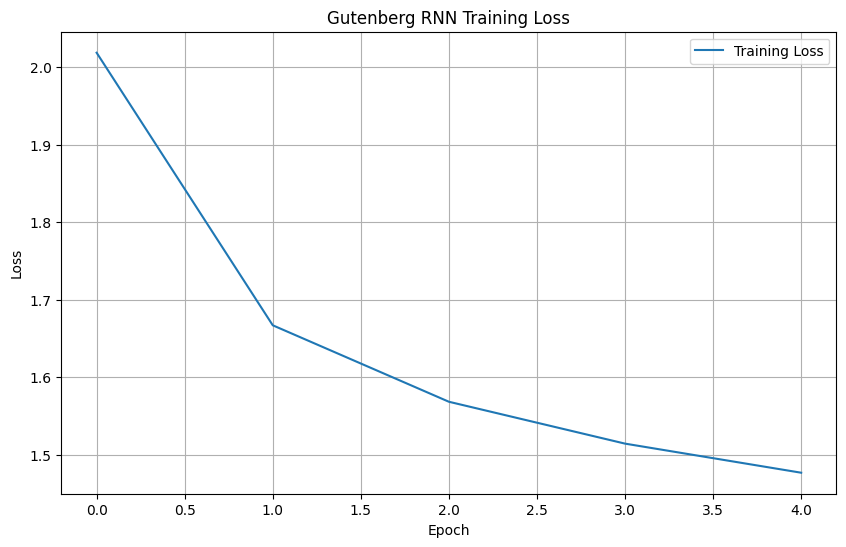

2025-09-07 10:52:26,300 - __main__ - INFO - Training loss plot created
2025-09-07 10:52:26,300 - __main__ - INFO - Gutenberg RNN demonstration completed successfully
2025-09-07 10:52:26,301 - __main__ - INFO - Main execution completed successfully


In [11]:
if __name__ == "__main__":

    path_for_project_files = "project_files_directory"

    # Multiple books with concatenation
    Gutenberg_urls = [
        "https://www.gutenberg.org/ebooks/1513.txt.utf-8",  # Romeo and Juliet
        "https://www.gutenberg.org/ebooks/1514.txt.utf-8",  # Hamlet
        "https://www.gutenberg.org/ebooks/1515.txt.utf-8",  # Macbeth
    ]
    
    '''
    def get_gutenberg_books_outputs_corpus_file_path_with_individual_saves(
        book_urls: Union[str, List[str]],
        remove_text: bool = False,
        parent_file_directory: Optional[str] = None,
        corpus_filename: str = "corpus.txt",
        save_individual_books: bool = False,
        individual_books_subdirectory_name: str = "individual_books",
        individual_filename_prefix: str = "book_",
        individual_filename_suffix: str = ".txt",
        use_url_based_individual_filenames: bool = True,
        remove_individual_files_after_corpus_creation: bool = False
    ) -> Dict[str, Union[str, List[str], None]]:
    """
    '''

    result = get_gutenberg_books_outputs_corpus_file_path_with_individual_saves(
        book_urls=Gutenberg_urls,
        remove_text=False,
        parent_file_directory=path_for_project_files,
        corpus_filename="corpus.txt",
        save_individual_books=True,
        individual_books_subdirectory_name="individual_books",
        individual_filename_prefix="guten_book_",
        individual_filename_suffix=".txt",
        use_url_based_individual_filenames=True,
        remove_individual_files_after_corpus_creation=False,
    )

    # Access detailed results
    print(f"Downloaded {result['download_success_count']} books")
    print(f"Individual files: {result['individual_file_paths']}")
    print(f"Corpus file path: {result['corpus_file_path']}")

    corpus_file_path = result['corpus_file_path']

    """
    Main execution block for the Gutenberg RNN demonstration.

    This block runs the complete demonstration pipeline when the script
    is executed directly.
    """
    try:
        logger.info("Starting Gutenberg RNN main execution")
        run_Gutenberg_rnn_pipeline(
            corpus_file_path,
            path_for_project_files,
        )
        logger.info("Main execution completed successfully")
    except Exception as main_error:
        logger.error(f"Error in main execution: {main_error}")
        traceback.print_exc()
        sys.exit(1)